**Entropy & Gini - Fastset and High Capacity set of routers**

In [14]:
# STEP 1: Load & parse 4-Fastset-Nodes-By-Time.txt  →  DataFrame[timestamp, node_id]

import re
import pandas as pd
import numpy as np

BASE = "/content/drive/MyDrive/DataInBrief-2025"
PATH_FASTSET_TIME = f"{BASE}/4-Fastset-Nodes-By-Time.txt"

# Router ID (I2P) regex: supports ~, -, +, / and optional '=' padding
ROUTER_ID_RE = re.compile(r"([A-Za-z0-9\-\~\+\/]{43}=|[A-Za-z0-9\-\~\+\/]{44})")

def sniff(path, n=5):
    print(f"\n--- SNiff: {path} ---")
    with open(path, "r", errors="ignore") as f:
        for i, ln in enumerate(f):
            if i >= n: break
            print(f"{i+1:02d}: {ln.rstrip()}")

def load_fastset_time_tabfile(path: str) -> pd.DataFrame:
    """
    Expect lines like: Date<TAB>Time<TAB>I2P Routers<TAB>Tunnel Node ID
    Example:
        11/17/2024\t0:18:04\t32874\tX9HFL...=
    """
    rows = []
    bad = 0
    with open(path, "r", errors="ignore") as f:
        for ln in f:
            if not ln.strip():
                continue
            parts = [p for p in ln.rstrip("\n").split("\t") if p != ""]
            if len(parts) < 3:
                bad += 1
                continue

            # date + time are the first two fields
            date_str = parts[0].strip()
            time_str = parts[1].strip()

            # router id: try regex anywhere in the line (more robust than trusting last column)
            m = ROUTER_ID_RE.search(ln)
            if not m:
                # fallback: take last non-empty token
                rid = parts[-1].strip()
                # sanity check (length ~44)
                if len(rid) < 40:
                    bad += 1
                    continue
            else:
                rid = m.group(0)

            # build timestamp from "M/D/YYYY H:MM:SS"
            ts = pd.to_datetime(f"{date_str} {time_str}", errors="coerce", infer_datetime_format=True)
            if pd.isna(ts):
                bad += 1
                continue

            rows.append((ts, rid))

    df = pd.DataFrame(rows, columns=["timestamp", "node_id"]).sort_values("timestamp").reset_index(drop=True)
    print(f"[FastSet-by-time] parsed rows: {len(df)} | skipped lines: {bad}")
    if not df.empty:
        print(f"  time range : {df['timestamp'].min()} → {df['timestamp'].max()}")
        print(f"  unique nodes: {df['node_id'].nunique()}")
    return df

# (1) quick sniff so you can verify the top few lines match expectations
sniff(PATH_FASTSET_TIME, n=5)

# (2) load to DataFrame
df_fast = load_fastset_time_tabfile(PATH_FASTSET_TIME)

# (3) show a small sample (head) to confirm structure
print("\nHEAD:")
print(df_fast.head(10))



--- SNiff: /content/drive/MyDrive/DataInBrief-2025/4-Fastset-Nodes-By-Time.txt ---
01: 11/17/2024	0:18:04	32874	X9HFLg4WWC6prjzNKrp22BKdk6bNZNkML8PyMBYLIyg=
02: 11/17/2024	0:18:04	32874	PqhKjinhCE4WUwws~lmrzfhkmO4GKCpf3DhKB2fJ~XI=
03: 11/17/2024	0:18:04	32874	tUE6jMt-2BPkH16T61C2uLwN1RK~WHmmQ9HjS6yaUzY=
04: 11/17/2024	0:18:04	32874	PHCL4h702mp~2h4Ua-7JlBgEbK0zDtDnAa3HBXiGg5g=
05: 11/17/2024	0:18:04	32874	mdFSIC6UpvS15ANdGVGpvnytedyN-dGqWhxH65eHd9c=


/tmp/ipython-input-379222488.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts = pd.to_datetime(f"{date_str} {time_str}", errors="coerce", infer_datetime_format=True)


[FastSet-by-time] parsed rows: 345320 | skipped lines: 1
  time range : 2024-11-17 00:18:04 → 2024-11-17 01:11:17
  unique nodes: 2076

HEAD:
            timestamp                                       node_id
0 2024-11-17 00:18:04  X9HFLg4WWC6prjzNKrp22BKdk6bNZNkML8PyMBYLIyg=
1 2024-11-17 00:18:04  2YRI1wJs501UJCCKMtgn6aGePt4ZNFbhU267tOBfvII=
2 2024-11-17 00:18:04  EFTOlmPnKFE-L8SEF5FcLZ6vRvOPpwGyXluVMspsoAE=
3 2024-11-17 00:18:04  EFTOlmPnKFE-L8SEF5FcLZ6vRvOPpwGyXluVMspsoAE=
4 2024-11-17 00:18:04  2YRI1wJs501UJCCKMtgn6aGePt4ZNFbhU267tOBfvII=
5 2024-11-17 00:18:04  N-xrnIhjuXftGRW8Pd4~feHWvr2yOi~jNbz61hybujE=
6 2024-11-17 00:18:04  ~My2WzL0JSBzMD2WMGEXqmAD0aK3i7scQ3S5D7rGXjA=
7 2024-11-17 00:18:04  OTMZ0JagZ0pdq4SshlwnszrgnfDBQWfmhTmlNTOyie4=
8 2024-11-17 00:18:04  ~K3A1N1Hq1GRRxoTAmnmMCRz8I0A3sZJYPLxGA8TSAk=
9 2024-11-17 00:18:04  eeyQrPJ04ANoyI29zH8vtIoUR5YmdVxmbXIq-dm7R1I=


In [15]:
# STEP 2: Load Profiles (10-Profiles-By-Country-anonymized.csv) and normalize
import pandas as pd
import numpy as np

BASE = "/content/drive/MyDrive/DataInBrief-2025"
PATH_PROFILES_ANON  = f"{BASE}/10-Profiles-By-Country-anonymized.csv"

prof = pd.read_csv(PATH_PROFILES_ANON, low_memory=False)
prof.columns = [c.strip() for c in prof.columns]  # trim header whitespace

# Find the node id column (use "Full Node ID" per your screenshot, with fallbacks)
id_col = None
for c in prof.columns:
    cl = c.strip().lower()
    if cl in {"full node id", "full_node_id", "node_id", "routerid", "router_id", "id"}:
        id_col = c
        break
if id_col is None:
    raise ValueError(f"Profiles: couldn't find a node-id column. Columns seen: {prof.columns.tolist()[:12]}")

prof = prof.rename(columns={id_col: "node_id"})
prof["node_id"] = prof["node_id"].astype(str).str.strip()

# Find Caps column (case-insensitive; tolerate variants)
caps_col = None
for c in prof.columns:
    if c.strip().lower() == "caps" or "cap" in c.strip().lower():
        caps_col = c
        break
if caps_col is None:
    prof["Caps"] = ""
else:
    prof = prof.rename(columns={caps_col: "Caps"})
    prof["Caps"] = prof["Caps"].astype(str).fillna("")

# Derive capability flags: X / f / R and combo XfR
prof["has_X"]   = prof["Caps"].str.contains("X", case=False, regex=False)
prof["has_f"]   = prof["Caps"].str.contains("f", case=False, regex=False)
prof["has_R"]   = prof["Caps"].str.contains("R", case=False, regex=False)
prof["has_XfR"] = prof["has_X"] & prof["has_f"] & prof["has_R"]

print(f"[Profiles] rows={len(prof)}, unique node_ids={prof['node_id'].nunique()}")
print("Caps top 10:\n", prof["Caps"].value_counts().head(10))

# If Step 1 df_fast exists, show coverage
try:
    coverage = pd.Series(df_fast["node_id"].unique()).isin(prof["node_id"].unique()).mean() * 100
    print(f"\nCoverage: FastSet nodes with a profile row = {coverage:.2f}%")
except NameError:
    print("\nNote: run Step 1 first if you want the coverage stat.")

print("\nHEAD:")
print(prof[["node_id","Caps","has_X","has_f","has_R","has_XfR"]].head(8))


[Profiles] rows=51399, unique node_ids=15111
Caps top 10:
 Caps
nan    23346
LU      8432
XR      2397
PU      2171
XU      2051
XfR     2003
PR      1623
LR      1580
NR      1413
PUE     1074
Name: count, dtype: int64

Coverage: FastSet nodes with a profile row = 50.96%

HEAD:
                                        node_id Caps  has_X  has_f  has_R  \
0  BcSrNByfccURPhma-AEb-wsDQu61vd8jAcqVlULf~~Y=   NR  False  False   True   
1  CYnynJEC9hABDO7aqB3qEUeNvTDJVi-Cn0Vf1FEqfpM=   PR  False  False   True   
2  C4k~z3uTdUPvV98kiue8LndgaZZh6wr2WNge001lNN0=   XR   True  False   True   
3  DD-Z7MisT81SLCQfHVaSGN3XNqTqScmz2vg0VPT0kjc=   NR  False  False   True   
4  DhgvH1dPUa34THMyorb6OnIF7uUOZant9BzzdGiPGok=   XR   True  False   True   
5  Dm8d207AoBGsyK9~KtQBtZS7G6nlmzzeYTlRzfbIRps=   PR  False  False   True   
6  Dz0S8jPgLLsz2XHZXEYaXy6arMinpNXi9WQiglj4Ghw=   PR  False  False   True   
7  D91E5tbo0pUyWKNo6D1dAsJQo7rJLAiSSxAiRwL7iv0=   XR   True  False   True   

   has_XfR  
0    False  


In [17]:
# STEP 3: Rolling entropy & Gini + capability shares (X, f, R, XfR)
import numpy as np
import pandas as pd

# ---- prerequisites ----
assert 'df_fast' in globals() and not df_fast.empty, "Run Step 1 first to create a non-empty df_fast."
assert 'prof' in globals() and not prof.empty, "Run Step 2 first to create a non-empty prof."

# ---- helpers ----
def shannon_entropy_from_counts(counts):
    c = np.asarray(counts, dtype=float)
    c = c[c > 0]
    if c.size == 0:
        return 0.0
    p = c / c.sum()
    p = np.clip(p, 1e-300, 1.0)
    return float(-(p * np.log2(p)).sum())

def gini_from_counts(counts):
    c = np.asarray(counts, dtype=float)
    c = c[c > 0]
    if c.size == 0:
        return 0.0
    s = np.sort(c)
    n = s.size
    cum = np.cumsum(s)
    tot = s.sum()
    if tot == 0:
        return 0.0
    return float(1.0 - (2.0 * cum.sum()) / (n * tot) + (1.0 / n))

# ---- window params (reviewer wanted rolling windows) ----
WINDOW = "2h"      # use 'h' not 'H'
STEP   = "30min"   # use 'min' not 'T'

# ---- build windows over the FastSet stream ----
df_fast_idx = df_fast.sort_values('timestamp').set_index('timestamp')
grid = pd.date_range(df_fast_idx.index.min(), df_fast_idx.index.max(), freq=STEP)

rows = []
for t0 in grid:
    t1 = t0 + pd.Timedelta(WINDOW)
    w = df_fast_idx.loc[t0:t1]
    if w.empty:
        continue

    vc = w['node_id'].value_counts()
    if vc.size < 2:
        continue

    ent = shannon_entropy_from_counts(vc.values)
    gin = gini_from_counts(vc.values)

    # capability shares in this window (based on unique nodes)
    uniq_nodes = vc.index.to_series().reset_index(drop=True).to_frame(name='node_id')
    j = uniq_nodes.merge(prof[['node_id','Caps']], on='node_id', how='left')
    caps = j['Caps'].astype(str).fillna('')

    has_X   = caps.str.contains('X', case=False, regex=False)
    has_f   = caps.str.contains('f', case=False, regex=False)
    has_R   = caps.str.contains('R', case=False, regex=False)
    has_XfR = has_X & has_f & has_R

    denom = max(len(j), 1)
    rows.append({
        'window_start': t0,
        'window_end': t1,
        'num_selections': int(len(w)),
        'unique_nodes': int(vc.size),
        'entropy': float(ent),
        'gini': float(gin),
        'share_X':   float(has_X.sum()/denom),
        'share_f':   float(has_f.sum()/denom),
        'share_R':   float(has_R.sum()/denom),
        'share_XfR': float(has_XfR.sum()/denom),
    })

df_win = pd.DataFrame(rows).sort_values('window_start').reset_index(drop=True)
print(f"[Step 3] windows computed: {len(df_win)}")
if not df_win.empty:
    display(df_win.head(10))
else:
    print("No windows produced. Check df_fast time span and that each window has >=2 unique nodes.")


[Step 3] windows computed: 2


,window_start,window_end,num_selections,unique_nodes,entropy,gini,share_X,share_f,share_R,share_XfR
0,2024-11-17 00:18:04,2024-11-17 02:18:04,345320,2076,10.255765,0.537400,0.306198,0.083441,0.504903,0.066975
1,2024-11-17 00:48:04,2024-11-17 02:48:04,156848,1534,10.019793,0.466028,0.322805,0.087789,0.518776,0.071624


In [18]:
# STEP 4: Correlations (entropy/Gini ↔ Caps shares) + simple stability stats

import numpy as np
import pandas as pd
from math import isnan

# prereqs
assert 'df_win' in globals() and not df_win.empty, "Run Step 3 first to create df_win."

# pick vars
x_vars = ["entropy", "gini"]
y_vars = ["share_X", "share_f", "share_R", "share_XfR"]

# --- Pearson & Spearman correlations with p-values ---
try:
    from scipy.stats import pearsonr, spearmanr
    have_scipy = True
except Exception:
    have_scipy = False
    print("SciPy not available; will compute correlation coefficients without p-values.")

rows = []
for x in x_vars:
    for y in y_vars:
        sub = df_win[[x, y]].dropna()
        r_pear = sub[x].corr(sub[y], method="pearson")
        r_spea = sub[x].corr(sub[y], method="spearman")
        if have_scipy and len(sub) >= 3:
            pr = pearsonr(sub[x], sub[y])
            sr = spearmanr(sub[x], sub[y])
            p_pear = float(pr.pvalue)
            p_spea = float(sr.pvalue) if not isinstance(sr.pvalue, np.ndarray) else float(sr.pvalue[0])
        else:
            p_pear = np.nan
            p_spea = np.nan

        rows.append({
            "x_metric": x,
            "y_share": y,
            "pearson_r": float(r_pear) if not isnan(r_pear) else np.nan,
            "pearson_p": p_pear,
            "spearman_rho": float(r_spea) if not isnan(r_spea) else np.nan,
            "spearman_p": p_spea,
            "n": int(len(sub))
        })

corr_table = pd.DataFrame(rows).sort_values(["x_metric","y_share"]).reset_index(drop=True)
print("[Step 4] Correlations (entropy/Gini vs Caps shares):")
display(corr_table)

# --- Simple stability statistics for reviewer (how stable over time?) ---
# lag-1 deltas and autocorrelation of entropy/gini
stab = {}
for x in x_vars:
    s = df_win[x].dropna()
    if len(s) >= 2:
        diff_abs_mean = float(s.diff().abs().dropna().mean())
        diff_abs_median = float(s.diff().abs().dropna().median())
        # lag-1 autocorr (requires >= 3 for a robust value)
        ac1 = float(s.autocorr(lag=1)) if len(s) >= 3 else np.nan
        stab[x] = {
            "n_windows": int(len(s)),
            "mean_abs_delta": diff_abs_mean,
            "median_abs_delta": diff_abs_median,
            "lag1_autocorr": ac1,
        }
    else:
        stab[x] = {"n_windows": int(len(s)), "mean_abs_delta": np.nan,
                   "median_abs_delta": np.nan, "lag1_autocorr": np.nan}

stab_df = pd.DataFrame(stab).T
print("\n[Step 4] Stability summary (smaller deltas = more stable; higher lag1 = more persistent):")
display(stab_df)

# (optional) quick peek
print("\n[Step 4] First few windows:")
display(df_win.head())


[Step 4] Correlations (entropy/Gini vs Caps shares):


,x_metric,y_share,pearson_r,pearson_p,spearman_rho,spearman_p,n
0,entropy,share_R,-1.0,NaN,-1.0,NaN,2
1,entropy,share_X,-1.0,NaN,-1.0,NaN,2
2,entropy,share_XfR,-1.0,NaN,-1.0,NaN,2
3,entropy,share_f,-1.0,NaN,-1.0,NaN,2
4,gini,share_R,-1.0,NaN,-1.0,NaN,2
5,gini,share_X,-1.0,NaN,-1.0,NaN,2
6,gini,share_XfR,-1.0,NaN,-1.0,NaN,2
7,gini,share_f,-1.0,NaN,-1.0,NaN,2



[Step 4] Stability summary (smaller deltas = more stable; higher lag1 = more persistent):


,n_windows,mean_abs_delta,median_abs_delta,lag1_autocorr
entropy,2.0,0.235972,0.235972,NaN
gini,2.0,0.071372,0.071372,NaN



[Step 4] First few windows:


,window_start,window_end,num_selections,unique_nodes,entropy,gini,share_X,share_f,share_R,share_XfR
0,2024-11-17 00:18:04,2024-11-17 02:18:04,345320,2076,10.255765,0.537400,0.306198,0.083441,0.504903,0.066975
1,2024-11-17 00:48:04,2024-11-17 02:48:04,156848,1534,10.019793,0.466028,0.322805,0.087789,0.518776,0.071624


In [19]:
# STEP 5: High-Capacity static entropy & Gini with cross-check to the set file

import re, pandas as pd, numpy as np

BASE = "/content/drive/MyDrive/DataInBrief-2025"
PATH_HICAP_SET  = f"{BASE}/6-High-Capacity-Set.txt"
PATH_HICAP_FREQ = f"{BASE}/7-High-Capacity-Set-Freq.txt"

# Router IDs look like base64-ish with ~,-,+,/ and '=' padding
ROUTER_ID_RE = re.compile(r"([A-Za-z0-9\-\~\+\/]{43}=|[A-Za-z0-9\-\~\+\/]{44})")

# --- metrics (reuse from Step 3 if present) ---
try:
    shannon_entropy_from_counts
    gini_from_counts
except NameError:
    def shannon_entropy_from_counts(counts):
        c = np.asarray(counts, dtype=float)
        c = c[c > 0]
        if c.size == 0: return 0.0
        p = np.clip(c / c.sum(), 1e-300, 1.0)
        return float(-(p * np.log2(p)).sum())

    def gini_from_counts(counts):
        c = np.asarray(counts, dtype=float)
        c = c[c > 0]
        if c.size == 0: return 0.0
        s = np.sort(c)
        n = s.size
        cum = np.cumsum(s)
        tot = s.sum()
        if tot == 0: return 0.0
        return float(1.0 - (2.0 * cum.sum()) / (n * tot) + (1.0 / n))

# --- loaders ---
def load_hicap_set_regex(path: str) -> pd.DataFrame:
    ids = []
    with open(path, "r", errors="ignore") as f:
        for ln in f:
            m = ROUTER_ID_RE.search(ln)
            if m:
                ids.append(m.group(0))
    df = pd.DataFrame({"node_id": pd.Series(ids, dtype=str)}).drop_duplicates().reset_index(drop=True)
    print(f"[HiCap-Set] unique node IDs: {len(df)}")
    return df

def load_hicap_freq_tab2(path: str) -> pd.DataFrame:
    # file appears as: <router_id>\t<freq>
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["node_id", "frequency"], engine="python", usecols=[0,1])
    df["node_id"] = df["node_id"].astype(str).str.strip()
    df["frequency"] = pd.to_numeric(df["frequency"], errors="coerce")
    df = df.dropna(subset=["node_id","frequency"])
    # if duplicates exist for a node, sum them
    df = df.groupby("node_id", as_index=False)["frequency"].sum()
    print(f"[HiCap-Freq] rows: {len(df)} | unique nodes: {df['node_id'].nunique()} | total freq: {int(df['frequency'].sum())}")
    return df

# --- run ---
df_hicap_set  = load_hicap_set_regex(PATH_HICAP_SET)
df_hicap_freq = load_hicap_freq_tab2(PATH_HICAP_FREQ)

# restrict to nodes that are in the declared high-capacity set (defensive)
hc_inter = pd.merge(df_hicap_freq, df_hicap_set, on="node_id", how="inner")
if hc_inter.empty:
    print("WARNING: No overlap between 6-High-Capacity-Set and 7-High-Capacity-Set-Freq; using all freq rows.")
    counts = df_hicap_freq["frequency"].values
    n_overlap = 0
else:
    counts = hc_inter["frequency"].values
    n_overlap = hc_inter["node_id"].nunique()

entropy_hc = shannon_entropy_from_counts(counts)
gini_hc    = gini_from_counts(counts)

summary = {
    "N_ids_in_set":         int(len(df_hicap_set)),
    "N_ids_in_freq":        int(df_hicap_freq["node_id"].nunique()),
    "N_overlap":            int(n_overlap),
    "total_frequency":      int(np.sum(counts)) if counts.size else 0,
    "min_frequency":        int(np.min(counts)) if counts.size else 0,
    "max_frequency":        int(np.max(counts)) if counts.size else 0,
    "mean_frequency":       float(np.mean(counts)) if counts.size else 0.0,
    "entropy_bits":         float(np.round(entropy_hc, 6)),
    "gini":                 float(np.round(gini_hc, 6)),
}

print("\n[Step 5] High-Capacity static metrics:")
for k, v in summary.items():
    print(f"  {k}: {v}")


[HiCap-Set] unique node IDs: 2132
[HiCap-Freq] rows: 1364 | unique nodes: 1364 | total freq: 22317

[Step 5] High-Capacity static metrics:
  N_ids_in_set: 2132
  N_ids_in_freq: 1364
  N_overlap: 634
  total_frequency: 12962
  min_frequency: 1
  max_frequency: 908
  mean_frequency: 20.444794952681388
  entropy_bits: 7.493428
  gini: 0.748134


[Export] Rolling metrics → /content/drive/MyDrive/DataInBrief-2025/outputs/fastset_rolling_entropy_gini.csv
[Export] Hi-cap static summary → /content/drive/MyDrive/DataInBrief-2025/outputs/high_capacity_static_summary.csv


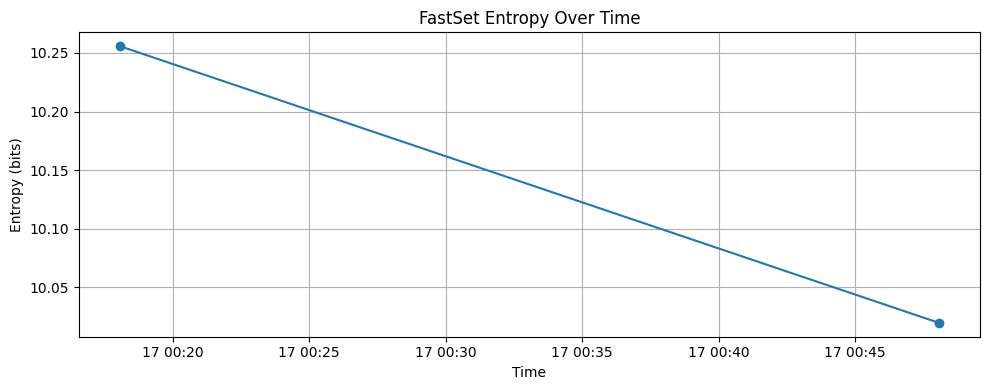

[Plot] /content/drive/MyDrive/DataInBrief-2025/outputs/fastset_entropy_over_time.png


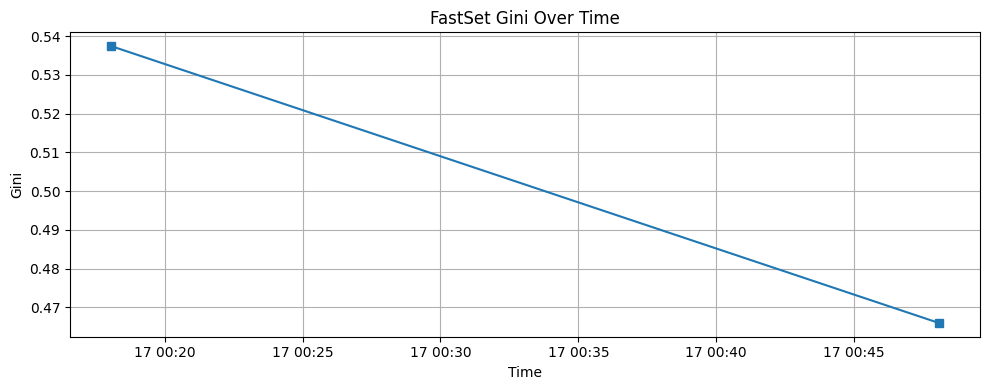

[Plot] /content/drive/MyDrive/DataInBrief-2025/outputs/fastset_gini_over_time.png
[Summary] Entropy mean±sd = 10.138 ± 0.167
[Summary] Gini    mean±sd = 0.502 ± 0.050


In [20]:
# STEP 6: Export results + minimal plots

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/DataInBrief-2025"
OUT  = f"{BASE}/outputs"
os.makedirs(OUT, exist_ok=True)

assert 'df_win' in globals(), "Run Step 3 first to create df_win."

# ---- 6A) Export rolling-window metrics ----
if not df_win.empty:
    roll_csv = f"{OUT}/fastset_rolling_entropy_gini.csv"
    df_win.to_csv(roll_csv, index=False)
    print(f"[Export] Rolling metrics → {roll_csv}")
else:
    print("[Export] df_win is empty; nothing to export for rolling metrics.")

# ---- 6B) Export high-capacity static summary ----
# If you still have 'summary' from Step 5, reuse it; otherwise, build a minimal one from available vars.
if 'summary' in globals():
    hc_summary = summary
else:
    hc_summary = {}
    if 'df_hicap_set' in globals():
        hc_summary["N_ids_in_set"] = int(len(df_hicap_set))
    if 'df_hicap_freq' in globals() and not df_hicap_freq.empty:
        counts = df_hicap_freq["frequency"].values
        hc_summary.update({
            "N_ids_in_freq": int(df_hicap_freq["node_id"].nunique()),
            "total_frequency": int(np.sum(counts)),
            "min_frequency": int(np.min(counts)),
            "max_frequency": int(np.max(counts)),
            "mean_frequency": float(np.mean(counts)),
        })
    # Try to compute entropy/gini if helpers & counts exist
    try:
        from math import isnan
        if 'df_hicap_freq' in globals() and not df_hicap_freq.empty:
            counts = df_hicap_freq["frequency"].values
            # define if not present
            if 'shannon_entropy_from_counts' not in globals():
                def shannon_entropy_from_counts(c):
                    c = np.asarray(c, dtype=float); c = c[c>0]
                    if c.size==0: return 0.0
                    p = np.clip(c/np.sum(c), 1e-300, 1.0)
                    return float(-(p*np.log2(p)).sum())
            if 'gini_from_counts' not in globals():
                def gini_from_counts(c):
                    c = np.asarray(c, dtype=float); c = c[c>0]
                    if c.size==0: return 0.0
                    s = np.sort(c); n = s.size; cum = np.cumsum(s); tot = s.sum()
                    if tot==0: return 0.0
                    return float(1.0 - (2.0*cum.sum())/(n*tot) + (1.0/n))
            hc_summary["entropy_bits"] = float(np.round(shannon_entropy_from_counts(counts), 6))
            hc_summary["gini"] = float(np.round(gini_from_counts(counts), 6))
    except Exception as e:
        print(f"[Warn] Could not compute entropy/gini for hi-cap fallback: {e}")

hc_df = pd.DataFrame([hc_summary])
hc_csv = f"{OUT}/high_capacity_static_summary.csv"
hc_df.to_csv(hc_csv, index=False)
print(f"[Export] Hi-cap static summary → {hc_csv}")

# ---- 6C) Minimal plots (optional but paper-friendly) ----
if not df_win.empty:
    # Entropy over time
    plt.figure(figsize=(10,4))
    plt.plot(df_win["window_start"], df_win["entropy"], marker="o")
    plt.title("FastSet Entropy Over Time")
    plt.xlabel("Time"); plt.ylabel("Entropy (bits)")
    plt.grid(True); plt.tight_layout()
    fig1 = f"{OUT}/fastset_entropy_over_time.png"
    plt.savefig(fig1, dpi=200)
    plt.show()
    print(f"[Plot] {fig1}")

    # Gini over time
    plt.figure(figsize=(10,4))
    plt.plot(df_win["window_start"], df_win["gini"], marker="s")
    plt.title("FastSet Gini Over Time")
    plt.xlabel("Time"); plt.ylabel("Gini")
    plt.grid(True); plt.tight_layout()
    fig2 = f"{OUT}/fastset_gini_over_time.png"
    plt.savefig(fig2, dpi=200)
    plt.show()
    print(f"[Plot] {fig2}")

    # Quick textual summary for the paper
    mean_ent = df_win["entropy"].mean()
    std_ent  = df_win["entropy"].std(ddof=1) if len(df_win)>1 else 0.0
    mean_g   = df_win["gini"].mean()
    std_g    = df_win["gini"].std(ddof=1) if len(df_win)>1 else 0.0
    print(f"[Summary] Entropy mean±sd = {mean_ent:.3f} ± {std_ent:.3f}")
    print(f"[Summary] Gini    mean±sd = {mean_g:.3f} ± {std_g:.3f}")
else:
    print("[Plot] skipped: df_win is empty.")


/tmp/ipython-input-2349984.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


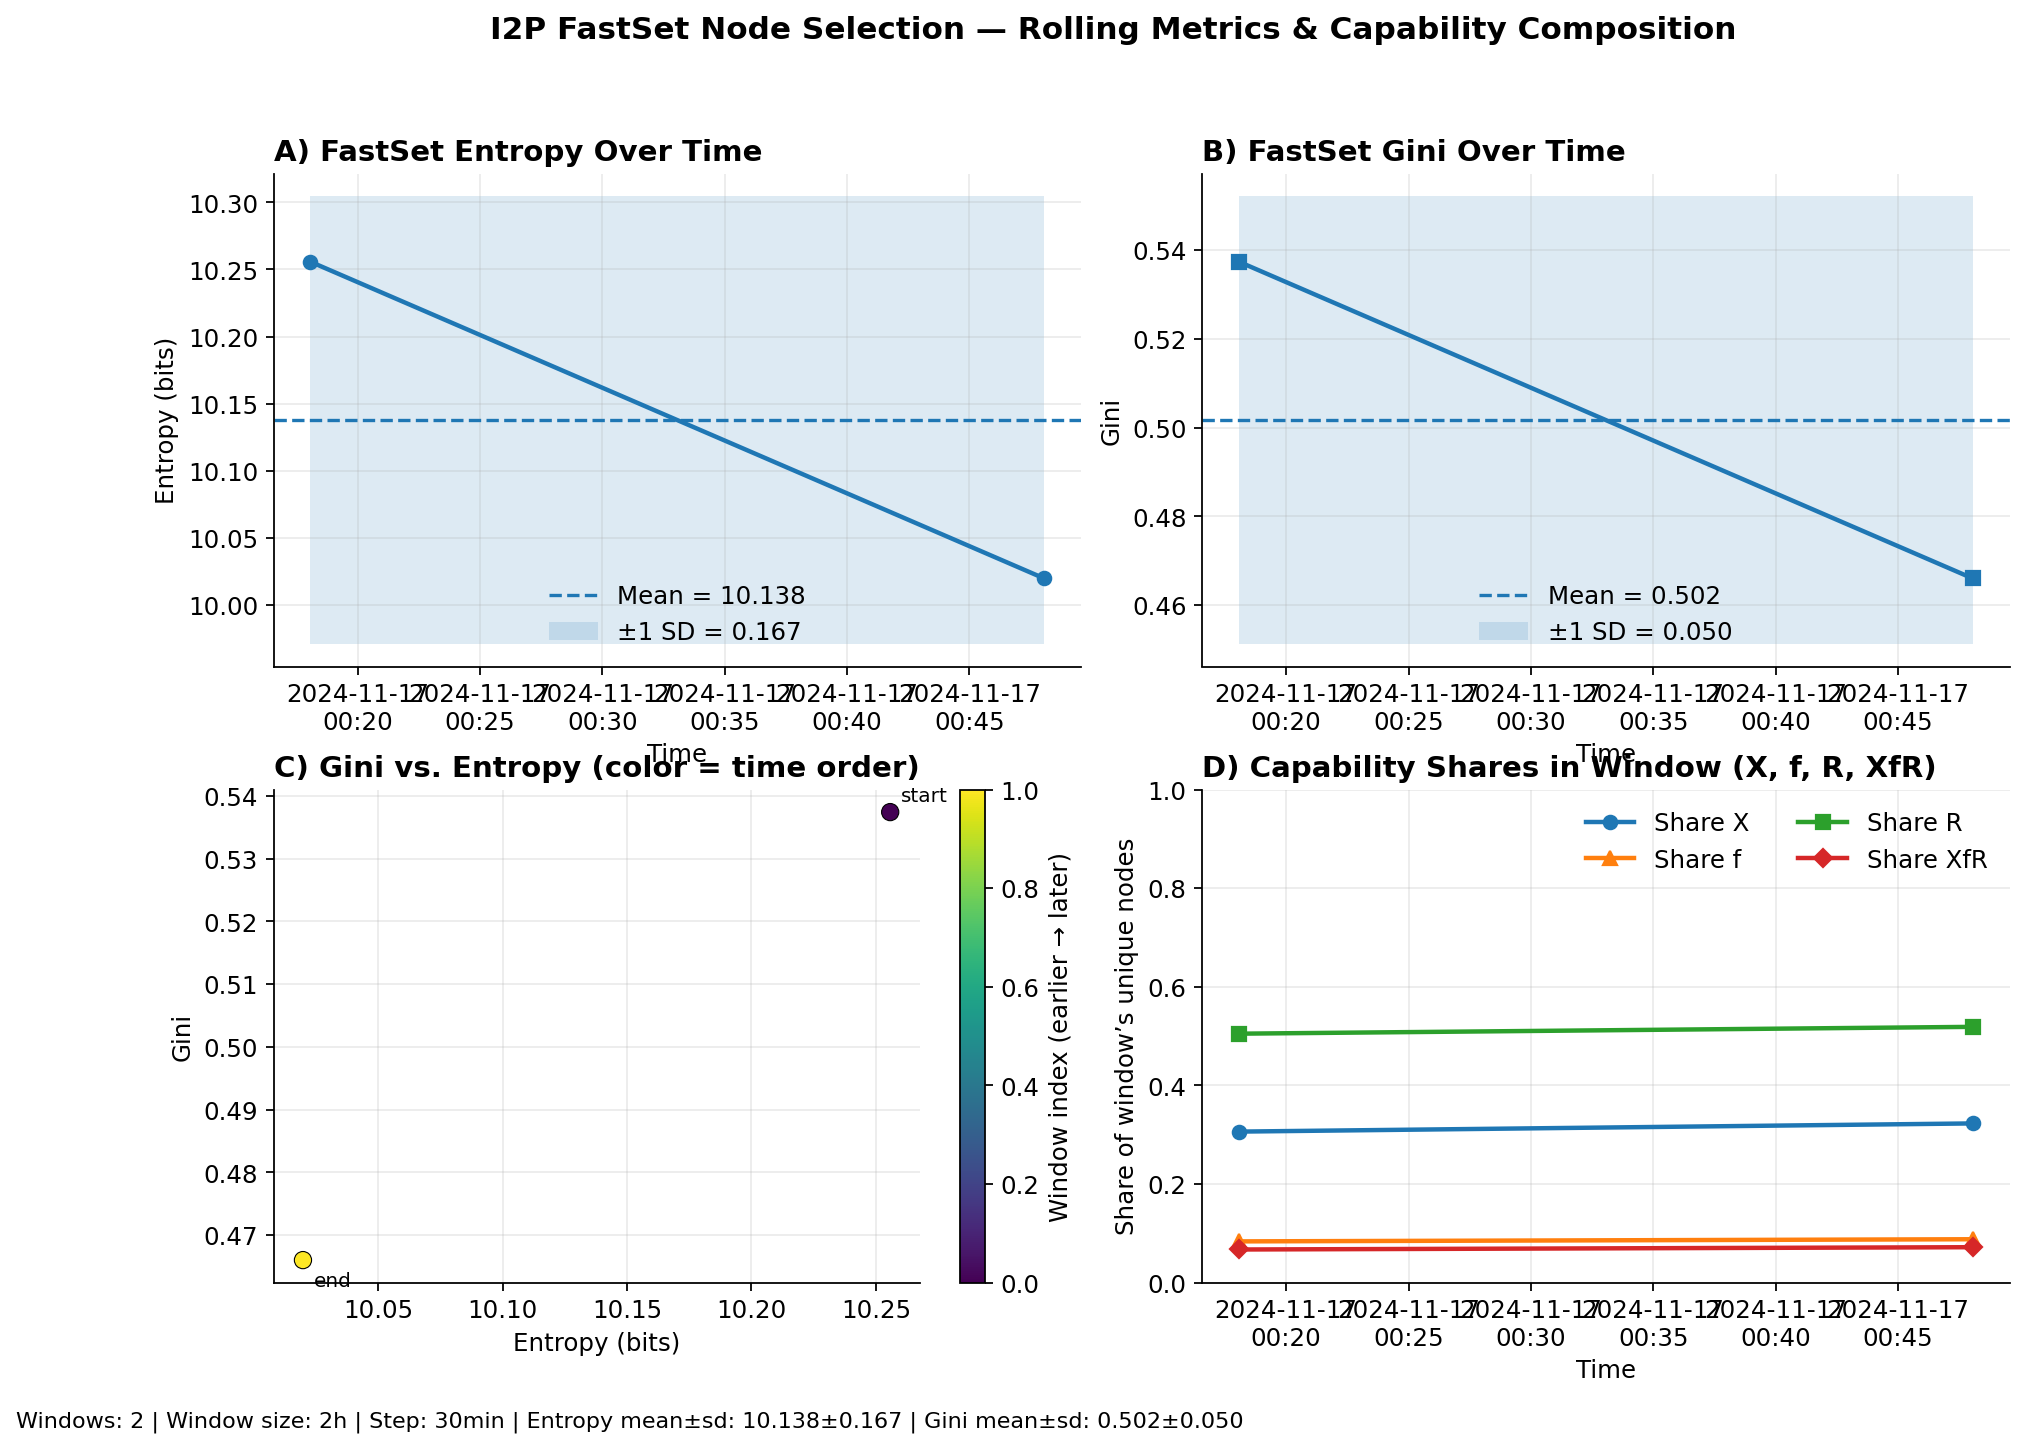

[Saved] /content/drive/MyDrive/DataInBrief-2025/outputs/fastset_composite.png


In [21]:
# ONE-FILE, MULTI-PANEL VISUALIZATION (nice colors, annotations, and a legend)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter

assert 'df_win' in globals() and not df_win.empty, "df_win missing. Run Steps 1–3 first."

# Sort & prep
dfp = df_win.sort_values('window_start').reset_index(drop=True).copy()
t = pd.to_datetime(dfp['window_start'])

# Stats
ent_mean, ent_std = dfp['entropy'].mean(), dfp['entropy'].std(ddof=1) if len(dfp)>1 else (dfp['entropy'].mean(), 0)
g_mean,  g_std    = dfp['gini'].mean(),    dfp['gini'].std(ddof=1)    if len(dfp)>1 else (dfp['gini'].mean(), 0)

# A clean style + readable fonts
mpl.rcParams.update({
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "figure.dpi": 160,
})

# Create figure
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1,1], width_ratios=[1,1], hspace=0.25, wspace=0.15)

# --- Panel A: Entropy over time ---
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(t, dfp['entropy'], marker='o', linewidth=2)
ax1.axhline(ent_mean, linestyle='--', linewidth=1.5, label=f"Mean = {ent_mean:.3f}")
if len(dfp)>1:
    ax1.fill_between(t, ent_mean-ent_std, ent_mean+ent_std, alpha=0.15, label=f"±1 SD = {ent_std:.3f}")
ax1.set_title("A) FastSet Entropy Over Time", loc='left', fontweight='bold')
ax1.set_xlabel("Time"); ax1.set_ylabel("Entropy (bits)")
ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
ax1.legend(frameon=False)

# --- Panel B: Gini over time ---
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(t, dfp['gini'], marker='s', linewidth=2)
ax2.axhline(g_mean, linestyle='--', linewidth=1.5, label=f"Mean = {g_mean:.3f}")
if len(dfp)>1:
    ax2.fill_between(t, g_mean-g_std, g_mean+g_std, alpha=0.15, label=f"±1 SD = {g_std:.3f}")
ax2.set_title("B) FastSet Gini Over Time", loc='left', fontweight='bold')
ax2.set_xlabel("Time"); ax2.set_ylabel("Gini")
ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
ax2.legend(frameon=False)

# --- Panel C: Entropy vs. Gini scatter (colored by time order) ---
ax3 = fig.add_subplot(gs[1,0])
order = np.arange(len(dfp))
sc = ax3.scatter(dfp['entropy'], dfp['gini'], c=order, cmap='viridis', s=60, edgecolor='k', linewidths=0.5)
ax3.set_title("C) Gini vs. Entropy (color = time order)", loc='left', fontweight='bold')
ax3.set_xlabel("Entropy (bits)"); ax3.set_ylabel("Gini")
cbar = fig.colorbar(sc, ax=ax3)
cbar.set_label("Window index (earlier → later)")

# annotate first/last to help with tiny series
if len(dfp) >= 1:
    ax3.annotate("start", xy=(dfp['entropy'].iloc[0], dfp['gini'].iloc[0]), xytext=(5,5),
                 textcoords="offset points", fontsize=9, color='black')
if len(dfp) >= 2:
    ax3.annotate("end",   xy=(dfp['entropy'].iloc[-1], dfp['gini'].iloc[-1]), xytext=(5,-12),
                 textcoords="offset points", fontsize=9, color='black')

# --- Panel D: Capability shares over time (X, f, R, XfR) ---
ax4 = fig.add_subplot(gs[1,1])
ax4.plot(t, dfp['share_X'],   marker='o', linewidth=2, label="Share X")
ax4.plot(t, dfp['share_f'],   marker='^', linewidth=2, label="Share f")
ax4.plot(t, dfp['share_R'],   marker='s', linewidth=2, label="Share R")
ax4.plot(t, dfp['share_XfR'], marker='D', linewidth=2, label="Share XfR")
ax4.set_title("D) Capability Shares in Window (X, f, R, XfR)", loc='left', fontweight='bold')
ax4.set_xlabel("Time"); ax4.set_ylabel("Share of window’s unique nodes")
ax4.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
ax4.set_ylim(0, 1)
ax4.legend(ncol=2, frameon=False)

# Super-title and footnote
fig.suptitle("I2P FastSet Node Selection — Rolling Metrics & Capability Composition", fontsize=14, fontweight='bold', y=0.99)
note = (f"Windows: {len(dfp)} | Window size: 2h | Step: 30min | "
        f"Entropy mean±sd: {ent_mean:.3f}±{ent_std:.3f} | Gini mean±sd: {g_mean:.3f}±{g_std:.3f}")
fig.text(0.01, 0.01, note, fontsize=10)

# Save a single composite PNG next to your other outputs
out_path = "/content/drive/MyDrive/DataInBrief-2025/outputs/fastset_composite.png"
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(out_path, dpi=220)
plt.show()

print(f"[Saved] {out_path}")


In [22]:
# STEP 7: Add normalized entropy (H / log2(K)) and re-check correlations

import numpy as np
import pandas as pd

assert 'df_win' in globals() and not df_win.empty, "Run Step 3 first."
# Add H_max and normalized entropy
df_win['H_max'] = np.log2(df_win['unique_nodes'].clip(lower=1))
df_win['entropy_norm'] = (df_win['entropy'] / df_win['H_max']).clip(upper=1.0)

print("[Step 7] Normalized entropy preview:")
print(df_win[['window_start','unique_nodes','entropy','H_max','entropy_norm']].head(10))

# Correlate normalized entropy and Gini with capability shares
cols_x = ['entropy', 'entropy_norm', 'gini']
cols_y = ['share_X','share_f','share_R','share_XfR']

corr_norm = df_win[cols_x + cols_y].corr(method='pearson').loc[cols_x, cols_y]
print("\n[Step 7] Pearson correlations (entropy, entropy_norm, gini vs capability shares):")
print(corr_norm)

# (Optional) save the updated df_win for your paper appendix
# df_win.to_csv("/content/drive/MyDrive/DataInBrief-2025/outputs/fastset_rolling_with_norm.csv", index=False)


[Step 7] Normalized entropy preview:
         window_start  unique_nodes    entropy      H_max  entropy_norm
0 2024-11-17 00:18:04          2076  10.255765  11.019591      0.930685
1 2024-11-17 00:48:04          1534  10.019793  10.583083      0.946775

[Step 7] Pearson correlations (entropy, entropy_norm, gini vs capability shares):
              share_X  share_f  share_R  share_XfR
entropy          -1.0     -1.0     -1.0       -1.0
entropy_norm      1.0      1.0      1.0        1.0
gini             -1.0     -1.0     -1.0       -1.0


In [23]:
# STEP 9 (optional): Save rolling results with normalized entropy for appendix
import numpy as np

df_win['H_max'] = np.log2(df_win['unique_nodes'].clip(lower=1))
df_win['entropy_norm'] = (df_win['entropy'] / df_win['H_max']).clip(upper=1.0)

out_path = "/content/drive/MyDrive/DataInBrief-2025/outputs/fastset_rolling_with_norm.csv"
df_win.to_csv(out_path, index=False)
print(f"[Saved] {out_path}")


[Saved] /content/drive/MyDrive/DataInBrief-2025/outputs/fastset_rolling_with_norm.csv


**Total and Cumulative % for the Top-20**